In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    semilogx,
    subplot,
    title,
    xlabel,
    ylabel,
)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
import torch
from dtuimldmtools import train_neural_net

from scipy.stats import ttest_rel

In [3]:
# Function for preprocessing
def preprocess_data(filepath):
    # Load dataset
    data = pd.read_csv(filepath)
    
    # Check for missing values and print counts
    print(f"Missing values in 'Age': {data['Age'].isna().sum()}")
    print(f"Missing values in 'Pclass': {data['Pclass'].isna().sum()}")
    print(f"Missing values in 'Sex': {data['Sex'].isna().sum()}")
    print(f"Missing values in 'Embarked': {data['Embarked'].isna().sum()}")
    print(f"Missing values in 'Parch': {data['Parch'].isna().sum()}")
    print(f"Missing values in 'SibSp': {data['SibSp'].isna().sum()}")
    print(f"Missing values in 'Fare': {data['Fare'].isna().sum()}")
    
    # Impute missing values
    age_imputer = SimpleImputer(strategy="median")
    data["Age"] = age_imputer.fit_transform(data[["Age"]])
    
    embarked_imputer = SimpleImputer(strategy="most_frequent")
    data["Embarked"] = embarked_imputer.fit_transform(data[["Embarked"]]).ravel()

    data['Fare'] = np.log1p(data['Fare'])

    # Drop irrelevant columns
    data = data.drop(columns=["PassengerId", "Name", "Ticket", "Cabin", "Survived"])
    
    # Encode categorical variables (keep all classes)
    data = pd.get_dummies(data, columns=["Sex", "Embarked"], drop_first=True)
    data = pd.get_dummies(data, columns=["Pclass"], drop_first=False)

    # Split features and target
    X = data.drop(columns=["Fare"])
    y = data["Fare"]

    # Store feature names before scaling
    feature_names = list(data.drop(columns=["Fare"]).columns)
    print("Feature Names:", feature_names)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("Preprocessing completed.")
    return X_train_scaled, X_test_scaled, y_train, y_test, feature_names

In [4]:
# Preprocess the data
X_train_scaled, X_test_scaled, y_train, y_test, feature_names = preprocess_data("titanic.csv")

# Define attribute names with intercept term
attributeNames = ["Intercept"] + feature_names
print("Attribute Names:", attributeNames)

Missing values in 'Age': 177
Missing values in 'Pclass': 0
Missing values in 'Sex': 0
Missing values in 'Embarked': 2
Missing values in 'Parch': 0
Missing values in 'SibSp': 0
Missing values in 'Fare': 0
Feature Names: ['Age', 'SibSp', 'Parch', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']
Preprocessing completed.
Attribute Names: ['Intercept', 'Age', 'SibSp', 'Parch', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']


In [5]:
# Regression task setup
def regression_task(X, y):
    # Number of features
    M = X.shape[1]  # Number of features
    print(f"Number of features: {M}")

    # Set up cross-validation
    K = 10  # Number of folds
    CV = model_selection.KFold(n_splits=K, shuffle=True, random_state=42)

    # Lambda range for regularization
    lambdas = np.power(10.0, range(-2, 6))

    print("Regression task setup complete. Ready for cross-validation.")
    return M, CV, lambdas

# Set up regression task
try:
    M, CV, lambdas = regression_task(X_train_scaled, y_train)
except Exception as e:
    print(f"An error occurred: {e}")
    raise

Number of features: 9
Regression task setup complete. Ready for cross-validation.


In [6]:
# Assume `X_train_scaled`, `X_test_scaled`, `y_train`, `y_test`, and `feature_names` come from preprocess_data
X = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])  # Add a bias (intercept) term
y = y_train.values if isinstance(y_train, pd.Series) else y_train  # Ensure y is a NumPy array

# Define the number of features
M = X.shape[1]  # Number of features (including the intercept)
print(f"Number of features: {M}")

# Define the number of folds for cross-validation
K = 10  # Number of cross-validation folds
CV = model_selection.KFold(n_splits=K, shuffle=True, random_state=42)

# Define range of lambda values (regularization parameters)
lambdas = np.power(10.0, range(-2, 6))  # Lambda values from 10^-2 to 10^5

# Initialize arrays to store training and test errors for unregularized regression
Error_train = np.empty((K, 1))  # Training errors for unregularized regression
Error_test = np.empty((K, 1))   # Test errors for unregularized regression

# Initialize arrays to store training and test errors for regularized regression
Error_train_rlr = np.empty((K, 1))  # Training errors for regularized regression
Error_test_rlr = np.empty((K, 1))   # Test errors for regularized regression

# Initialize array to store weights for regularized regression
w_rlr = np.empty((M, K))  # Shape: (number of features, number of folds)

# Initialize array to store weights for unregularized regression
w_noreg = np.empty((M, K))  # Shape: (number of features, number of folds)

# Store errors across lambda values for plotting
train_err_vs_lambda = []  # Training errors for each lambda
test_err_vs_lambda = []   # Test errors for each lambda

print(f"Initialized arrays for cross-validation with {K} folds.")

Number of features: 10
Initialized arrays for cross-validation with 10 folds.


In [7]:
def rlr_validate(X, y, lambdas, cvf=10):
    CV = model_selection.KFold(cvf, shuffle=True, random_state=42)
    M = X.shape[1]  # Number of features (including intercept)
    
    # Initialize storage
    w = np.empty((M, cvf, len(lambdas)))
    train_error = np.empty((cvf, len(lambdas)))
    test_error = np.empty((cvf, len(lambdas)))
    
    f = 0  # Fold counter
    y = y.squeeze()  # Ensure y is 1D if provided as 2D
    
    # Cross-validation loop
    for train_index, test_index in CV.split(X, y):
        # Split data into training and test folds
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        
        # Precompute terms
        Xty = X_train.T @ y_train
        XtX = X_train.T @ X_train
        
        # Regularization loop
        for l, lambda_val in enumerate(lambdas):
            # Regularization term, excluding bias term
            lambdaI = lambda_val * np.eye(M)
            lambdaI[0, 0] = 0  # Exclude bias regularization
            
            # Compute ridge regression weights
            w[:, f, l] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
            
            # Calculate train/test errors
            train_error[f, l] = np.mean(np.square(y_train - X_train @ w[:, f, l]))
            test_error[f, l] = np.mean(np.square(y_test - X_test @ w[:, f, l]))
        
        f += 1
    
    # Calculate mean errors and optimal lambda
    opt_val_err = np.min(np.mean(test_error, axis=0))
    opt_lambda = lambdas[np.argmin(np.mean(test_error, axis=0))]
    train_err_vs_lambda = np.mean(train_error, axis=0)
    test_err_vs_lambda = np.mean(test_error, axis=0)
    mean_w_vs_lambda = np.mean(w, axis=1)
    
    return opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda

Cross-validation fold 1:
Age: Average coefficient magnitude: 2.9498
SibSp: Average coefficient magnitude: 0.0117
Parch: Average coefficient magnitude: 0.1800
Sex_male: Average coefficient magnitude: 0.1415
Embarked_Q: Average coefficient magnitude: 0.0623
Embarked_S: Average coefficient magnitude: 0.0390
Pclass_1: Average coefficient magnitude: 0.0693
Pclass_2: Average coefficient magnitude: 0.2848
Pclass_3: Average coefficient magnitude: 0.0395

Cross-validation fold 2:
Age: Average coefficient magnitude: 2.9676
SibSp: Average coefficient magnitude: 0.0163
Parch: Average coefficient magnitude: 0.1760
Sex_male: Average coefficient magnitude: 0.1346
Embarked_Q: Average coefficient magnitude: 0.0562
Embarked_S: Average coefficient magnitude: 0.0380
Pclass_1: Average coefficient magnitude: 0.0507
Pclass_2: Average coefficient magnitude: 0.3051
Pclass_3: Average coefficient magnitude: 0.0536

Cross-validation fold 3:
Age: Average coefficient magnitude: 2.9671
SibSp: Average coefficient mag

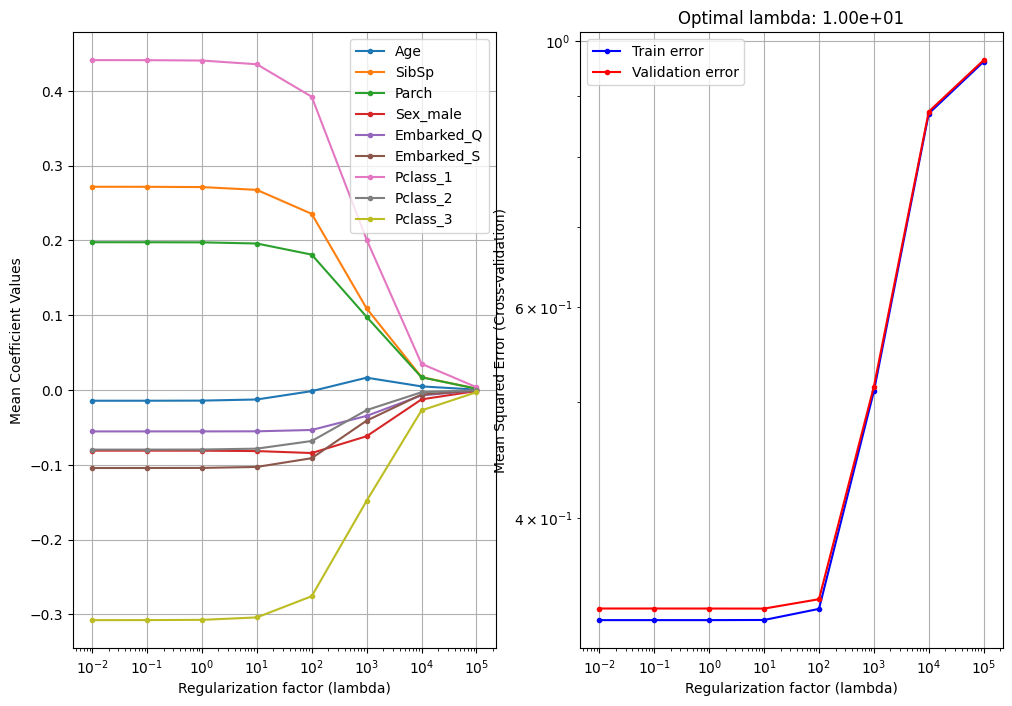

In [8]:
k = 0  # Cross-validation fold counter

# Perform outer cross-validation
for train_index, test_index in CV.split(X, y):
    # Extract training and test sets for the current fold
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    internal_cross_validation = 10  # Number of inner folds for lambda selection

    # Inner cross-validation to find the optimal lambda
    (
        opt_val_err,         # Minimum validation error across all tested lambdas
        opt_lambda,          # Lambda value with the minimum validation error
        mean_w_vs_lambda,    # Mean weight values across lambdas
        train_err_vs_lambda, # Training error for each lambda
        test_err_vs_lambda,  # Validation error for each lambda
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Debug to identify attributes with unusually high coefficients
    avg_coefs = np.mean(np.abs(mean_w_vs_lambda), axis=1)  # Calculate mean coefficient magnitude across lambdas
    print(f"Cross-validation fold {k+1}:")
    for i, attribute_name in enumerate(attributeNames[1:]):  # Skip the bias term
        print(f"{attribute_name}: Average coefficient magnitude: {avg_coefs[i]:.4f}")
    print()

    # Precompute XtX and Xty for the training set
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Regularized regression: Estimate weights for optimal lambda
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do not regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()

    # Compute errors with regularization
    Error_train_rlr[k] = np.mean(np.square(y_train - X_train @ w_rlr[:, k]))
    Error_test_rlr[k] = np.mean(np.square(y_test - X_test @ w_rlr[:, k]))

    # Unregularized regression: Estimate weights without regularization
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()

    # Compute errors without regularization
    Error_train[k] = np.mean(np.square(y_train - X_train @ w_noreg[:, k]))
    Error_test[k] = np.mean(np.square(y_test - X_test @ w_noreg[:, k]))

    # Visualization for the last cross-validation fold
    if k == K - 1:
        figure(figsize=(12, 8))

        # Plot mean weight values as a function of lambda
        subplot(1, 2, 1)
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Exclude bias term
        xlabel("Regularization factor (lambda)")
        ylabel("Mean Coefficient Values")
        grid()
        legend(attributeNames[1:], loc="best")  # Skip "Intercept" in legend

        # Plot train and validation errors as a function of lambda
        subplot(1, 2, 2)
        title(f"Optimal lambda: {opt_lambda:.2e}")
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-",
            lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor (lambda)")
        ylabel("Mean Squared Error (Cross-validation)")
        legend(["Train error", "Validation error"])
        grid()

    k += 1  # Increment fold counter

In [9]:
# Display results for linear regression
print("Linear regression without regularization:")
print(f"- Average training error: {Error_train.mean():.4f}")
print(f"- Average test error:     {Error_test.mean():.4f}")

# Display results for regularized linear regression
print("\nRegularized linear regression:")
print(f"- Average training error: {Error_train_rlr.mean():.4f}")
print(f"- Average test error:     {Error_test_rlr.mean():.4f}")

# Display weights in the last fold
print("\nWeights in the last fold:")
print(f"{'Attribute':>20} {'Weight (w_rlr)':>20}")
print("-" * 40)
# Start from the second index to skip the bias term (Intercept)
for m in range(1, M):
    print(f"{attributeNames[m]:>20} {w_rlr[m, -1]:>20.2f}")

Linear regression without regularization:
- Average training error: 0.3296
- Average test error:     0.3391

Regularized linear regression:
- Average training error: 0.3296
- Average test error:     0.3390

Weights in the last fold:
           Attribute       Weight (w_rlr)
----------------------------------------
                 Age                -0.01
               SibSp                 0.27
               Parch                 0.20
            Sex_male                -0.08
          Embarked_Q                -0.06
          Embarked_S                -0.10
            Pclass_1                 0.44
            Pclass_2                -0.08
            Pclass_3                -0.30


In [10]:
# Parameters
outer_folds = 10
kf_outer = KFold(n_splits=outer_folds, shuffle=True, random_state=42)

# Define hyperparameter ranges
lambdas = np.power(10.0, range(-2, 6))  # Regularization parameters for Ridge
hidden_layer_sizes = [1, 3, 5, 10]  # Number of hidden units for ANN
max_iter = 2000
n_replicates = 1

# Initialize storage for results
results_table = []

# Outer Loop: For each fold in outer cross-validation
for i, (train_index_outer, test_index_outer) in enumerate(kf_outer.split(X, y)):
    print(f"\nOuter Fold {i + 1}/{outer_folds}")

    # Split data into outer training and testing sets
    X_train_outer, X_test_outer = X[train_index_outer], X[test_index_outer]
    y_train_outer, y_test_outer = y[train_index_outer], y[test_index_outer]

    # ===============================
    # 1. Baseline Model
    # ===============================
    baseline_model = DummyRegressor(strategy="mean")
    baseline_model.fit(X_train_outer, y_train_outer)
    baseline_predictions = baseline_model.predict(X_test_outer)
    baseline_error = np.mean((y_test_outer - baseline_predictions) ** 2)

    # ===============================
    # 2. Regularized Linear Regression
    # ===============================
    best_lambda = None
    best_ridge_error = float("inf")
    kf_inner = KFold(n_splits=5, shuffle=True, random_state=42)  # Inner folds

    for lambda_value in lambdas:
        inner_errors = []
        for train_index_inner, val_index_inner in kf_inner.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_index_inner], X_train_outer[val_index_inner]
            y_train_inner, y_val_inner = y_train_outer[train_index_inner], y_train_outer[val_index_inner]

            # Train Ridge Regression on inner training set
            ridge_model = Ridge(alpha=lambda_value)
            ridge_model.fit(X_train_inner, y_train_inner)
            val_predictions = ridge_model.predict(X_val_inner)
            inner_error = np.mean((y_val_inner - val_predictions) ** 2)
            inner_errors.append(inner_error)

        # Calculate mean error for this lambda
        mean_inner_error = np.mean(inner_errors)
        if mean_inner_error < best_ridge_error:
            best_ridge_error = mean_inner_error
            best_lambda = lambda_value

    # Train Ridge Regression on outer training set with best lambda
    ridge_model = Ridge(alpha=best_lambda)
    ridge_model.fit(X_train_outer, y_train_outer)
    ridge_predictions = ridge_model.predict(X_test_outer)
    ridge_error = np.mean((y_test_outer - ridge_predictions) ** 2)

    # ===============================
    # 3. Artificial Neural Network
    # ===============================
    best_hidden_layer = None
    best_ann_error = float("inf")

    for hidden_layer in hidden_layer_sizes:
        inner_errors = []
        for train_index_inner, val_index_inner in kf_inner.split(X_train_outer):
            X_train_inner = torch.Tensor(X_train_outer[train_index_inner])
            y_train_inner = torch.Tensor(y_train_outer[train_index_inner]).unsqueeze(1)
            X_val_inner = torch.Tensor(X_train_outer[val_index_inner])
            y_val_inner = torch.Tensor(y_train_outer[val_index_inner]).unsqueeze(1)

            # Define ANN model
            model = lambda: torch.nn.Sequential(
                torch.nn.Linear(X_train_inner.shape[1], hidden_layer),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_layer, 1),
            )
            loss_fn = torch.nn.MSELoss()

            # Train ANN
            net, _, _ = train_neural_net(
                model, loss_fn, X_train_inner, y_train_inner, max_iter=max_iter
            )

            # Validate ANN
            val_predictions = net(X_val_inner)
            inner_error = torch.mean((val_predictions - y_val_inner) ** 2).item()
            inner_errors.append(inner_error)

        # Calculate mean error for this hidden layer size
        mean_inner_error = np.mean(inner_errors)
        if mean_inner_error < best_ann_error:
            best_ann_error = mean_inner_error
            best_hidden_layer = hidden_layer

    # Train ANN on outer training set with best hidden layer size
    X_train_outer_tensor = torch.Tensor(X_train_outer)
    y_train_outer_tensor = torch.Tensor(y_train_outer).unsqueeze(1)
    X_test_outer_tensor = torch.Tensor(X_test_outer)
    net, _, _ = train_neural_net(
        lambda: torch.nn.Sequential(
            torch.nn.Linear(X_train_outer_tensor.shape[1], best_hidden_layer),
            torch.nn.Tanh(),
            torch.nn.Linear(best_hidden_layer, 1),
        ),
        torch.nn.MSELoss(),
        X_train_outer_tensor,
        y_train_outer_tensor,
        max_iter=max_iter,
    )
    ann_predictions = net(X_test_outer_tensor)
    ann_error = torch.mean((ann_predictions - torch.Tensor(y_test_outer).unsqueeze(1)) ** 2).item()

    # Append results for this fold
    results_table.append({
        "Outer Fold": i + 1,
        "Linear Regression (λ*)": best_lambda,
        "Linear Regression (E_test)": ridge_error,
        "ANN (hidden_layer*)": best_hidden_layer,
        "ANN (E_test)": ann_error,
        "Baseline (E_test)": baseline_error,
    })


Outer Fold 1/10

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.1556904	0.002198745
		2000	0.49391904	0.0005224994
		Final loss:
		2000	0.49391904	0.0005224994

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	6.34056	0.00058564846


/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	0.8362455	0.00095967145
		Final loss:
		2000	0.8362455	0.00095967145

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	3.9580777	0.0005469443
		2000	2.2181373	0.0010266181
		Final loss:
		2000	2.2181373	0.0010266181

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.9867578	0.0012200888
		2000	0.47204676	0.0006347906
		Final loss:
		2000	0.47204676	0.0006347906

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	1.9265109	0.0005139447
		2000	1.3011255	0.00039710713
		Final loss:
		2000	1.3011255	0.00039710713

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.4662496	0.00047456686
		2000	0.36382732	6.691874e-05
		Final loss:
		2000	0.36382732	6.691874e-05

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.516139	0.0013759617
		2000	0.6789493	0.00041972112
		Final loss:
		2000	0.6789493	0.00041972112

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	3.8171883	0.00093819323
		2000	1.0205883	0.0006871555
		Final loss:
		2000	1.0205883	0.0006871555

	Replicate: 3/3
		Iter	Loss			Rel. loss
		10

/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	0.6315028	0.00058399874
		Final loss:
		2000	0.6315028	0.00058399874

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.58270097	0.0007670997
		2000	0.37529	0.00024420995
		Final loss:
		2000	0.37529	0.00024420995

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	3.713262	0.0015705444
		2000	1.1057616	0.0007784099
		Final loss:
		2000	1.1057616	0.0007784099

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	1.361547	0.0030541683
		2000	0.4513718	0.00049237825
		Final loss:
		2000	0.4513718	0.00049237825

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	3.2802625	0.0023878736
		2000	0.8051678	0.0007679644
		Final loss:
		2000	0.8051678	0.0007679644

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.8261409	0.0009667173
		2000	0.42113543	0.0004080859
		Final loss:
		2000	0.42113543	0.0004080859

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.76552355	0.0009606631
		2000	0.42177436	0.00042970706
		Final loss:
		2000	0.42177436	0.00042970706

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	

/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	0.48000702	0.00033639977
		Final loss:
		2000	0.48000702	0.00033639977

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.557243	0.00046454038
		2000	0.3546143	0.00022946471
		Final loss:
		2000	0.3546143	0.00022946471

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.6965238	0.000987836
		2000	0.41462934	0.0001937429
		Final loss:
		2000	0.41462934	0.0001937429

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	1.4966469	0.0018456037
		2000	0.5515958	0.0004785783
		Final loss:
		2000	0.5515958	0.0004785783

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	1.0314293	0.0048179557
		2000	0.52887434	0.00019572325
		Final loss:
		2000	0.52887434	0.00019572325

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.106392	0.001981823
		2000	0.4508557	0.0003806008
		Final loss:
		2000	0.4508557	0.0003806008

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	2.6814532	0.0005340874
		2000	0.5627013	0.00040246235
		Final loss:
		2000	0.5627013	0.00040246235

	Replicate: 3/3
		Iter	Loss			Rel. loss
		10

/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	0.49110466	0.00059823145
		Final loss:
		2000	0.49110466	0.00059823145

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	5.499106	0.0014925065
		2000	1.2202264	0.00094800617
		Final loss:
		2000	1.2202264	0.00094800617

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.3852241	0.0005158222
		2000	0.9047191	0.00041606888
		Final loss:
		2000	0.9047191	0.00041606888

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.8168378	0.00094909465
		2000	0.4985527	0.00030333945
		Final loss:
		2000	0.4985527	0.00030333945

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	4.812163	0.00067029055
		2000	1.0101808	0.0004135645
		Final loss:
		2000	1.0101808	0.0004135645

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	2.7513874	0.002556843
		2000	0.89195967	0.0005686192
		Final loss:
		2000	0.89195967	0.0005686192

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	2.9700725	0.0013270866
		2000	1.0827677	0.000732048
		Final loss:
		2000	1.0827677	0.000732048

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000

/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	2.0416806	0.00154966
		2000	0.73090917	0.00063665234
		Final loss:
		2000	0.73090917	0.00063665234

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.85366195	0.0010578746
		2000	0.4615585	0.0003032527
		Final loss:
		2000	0.4615585	0.0003032527

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.9935946	0.000990856
		2000	0.5867821	0.00032423608
		Final loss:
		2000	0.5867821	0.00032423608

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	1.291317	0.0012268504
		2000	0.6072754	0.00052708696
		Final loss:
		2000	0.6072754	0.00052708696

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	2.2914333	0.00086939515
		2000	0.62595755	0.0005321955
		Final loss:
		2000	0.62595755	0.0005321955

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.273747	0.00374838
		2000	0.47834727	0.00036819789
		Final loss:
		2000	0.47834727	0.00036819789

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.57195544	0.0007483073
		2000	0.39945436	0.000112495574
		Final loss:
		2000	0.39945436	0.000112495574

	Replicat

/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	0.99173355	0.0007017328
		Final loss:
		2000	0.99173355	0.0007017328

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	2.1687975	0.008107773
		2000	0.72242695	0.00044764276
		Final loss:
		2000	0.72242695	0.00044764276

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.9234032	0.0013532409
		2000	0.45524964	0.00033630477
		Final loss:
		2000	0.45524964	0.00033630477

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	2.744437	0.0016846729
		2000	0.8138705	0.00074974063
		Final loss:
		2000	0.8138705	0.00074974063

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	1.5700471	0.0013650515
		2000	0.64307296	0.00063506
		Final loss:
		2000	0.64307296	0.00063506

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	2.7128685	0.002178641
		2000	0.8058602	0.00070910744
		Final loss:
		2000	0.8058602	0.00070910744

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.7394456	0.0008479131
		2000	0.426812	0.00031244088
		Final loss:
		2000	0.426812	0.00031244088

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000

/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	1.1741325	0.0023197373
		Final loss:
		2000	1.1741325	0.0023197373

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	4.107697	0.0054130135
		2000	1.0048678	0.00040591188
		Final loss:
		2000	1.0048678	0.00040591188

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.7107259	0.0014351585
		2000	0.70986813	0.00051503273
		Final loss:
		2000	0.70986813	0.00051503273

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	1.1546593	0.0009948811
		2000	0.6120758	0.0004408448
		Final loss:
		2000	0.6120758	0.0004408448

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	1.3209243	0.00050521735
		2000	0.88018525	0.00051513844
		Final loss:
		2000	0.88018525	0.00051513844

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	8.668275	0.0007513045
		2000	1.0330969	0.001037665
		Final loss:
		2000	1.0330969	0.001037665

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	2.0757952	0.00055892376
		2000	0.58385676	0.0001524959
		Final loss:
		2000	0.58385676	0.0001524959

	Replicate: 3/3
		Iter	Loss			Rel. loss
		100

/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	0.927394	0.0006617471
		Final loss:
		2000	0.927394	0.0006617471

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	1.8410946	0.0015570548
		2000	0.7104595	0.00054033316
		Final loss:
		2000	0.7104595	0.00054033316

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.9609915	0.0010383208
		2000	0.48488352	0.0003887243
		Final loss:
		2000	0.48488352	0.0003887243

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	1.4112494	0.0014650229
		2000	0.5796794	0.0005413807
		Final loss:
		2000	0.5796794	0.0005413807

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	4.11787	0.0009418159
		2000	2.472008	0.00029831904
		Final loss:
		2000	2.472008	0.00029831904

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.87840635	0.000983817
		2000	0.5039655	0.00030989296
		Final loss:
		2000	0.5039655	0.00030989296

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	2.7608202	0.0010500444
		2000	1.6137531	0.00032935542
		Final loss:
		2000	1.6137531	0.00032935542

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	1.91

/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	0.41389215	9.597351e-05
		Final loss:
		2000	0.41389215	9.597351e-05

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	4.015184	0.0010884232
		2000	1.5693471	0.0080267275
		Final loss:
		2000	1.5693471	0.0080267275

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.88257	0.00088669464
		2000	0.48226655	0.0003468045
		Final loss:
		2000	0.48226655	0.0003468045

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.8851016	0.0012651033
		2000	0.47286323	0.00042435792
		Final loss:
		2000	0.47286323	0.00042435792

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.74977386	0.00087901804
		2000	0.45105252	0.00022413491
		Final loss:
		2000	0.45105252	0.00022413491

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.3248929	0.001556597
		2000	0.536618	0.0004928173
		Final loss:
		2000	0.536618	0.0004928173

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	3.357122	0.00089673
		2000	0.83419853	0.0006885314
		Final loss:
		2000	0.83419853	0.0006885314

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	

/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	2.0310185	0.001736094
		2000	0.69331706	0.0006243558
		Final loss:
		2000	0.69331706	0.0006243558

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.8179461	0.00086605124
		2000	0.4535336	0.00033948116
		Final loss:
		2000	0.4535336	0.00033948116

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	2.6159768	0.0007307682
		2000	1.7271776	0.00033297818
		Final loss:
		2000	1.7271776	0.00033297818

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.5260716	0.0005554346
		2000	0.38851818	0.00014311602
		Final loss:
		2000	0.38851818	0.00014311602

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	2.810001	0.0011883877
		2000	0.61690515	0.00026389296
		Final loss:
		2000	0.61690515	0.00026389296

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	2.28145	0.0013807713
		2000	0.867836	0.0006673487
		Final loss:
		2000	0.867836	0.0006673487

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	1.1428713	0.004252888
		2000	0.52491695	0.0005014151
		Final loss:
		2000	0.52491695	0.0005014151

	Replicate: 3/3


Two-level Cross-Validation Table:
   Outer Fold  Linear Regression (λ*)  Linear Regression (E_test)  \
0           1                     1.0                    0.326729   
1           2                     1.0                    0.590123   
2           3                     1.0                    0.547920   
3           4                    10.0                    0.198994   
4           5                    10.0                    0.262458   
5           6                    10.0                    0.300604   
6           7                     1.0                    0.214872   
7           8                     1.0                    0.180211   
8           9                    10.0                    0.425634   
9          10                     1.0                    0.344449   

   ANN (hidden_layer*)  ANN (E_test)  Baseline (E_test)  
0                   10      0.275581           0.996884  
1                    5      0.523106           1.027670  
2                   10      0.5

/var/folders/wp/8wwvjs5d0s12yxph92tsfw8c0000gn/T/ipykernel_4479/248787952.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


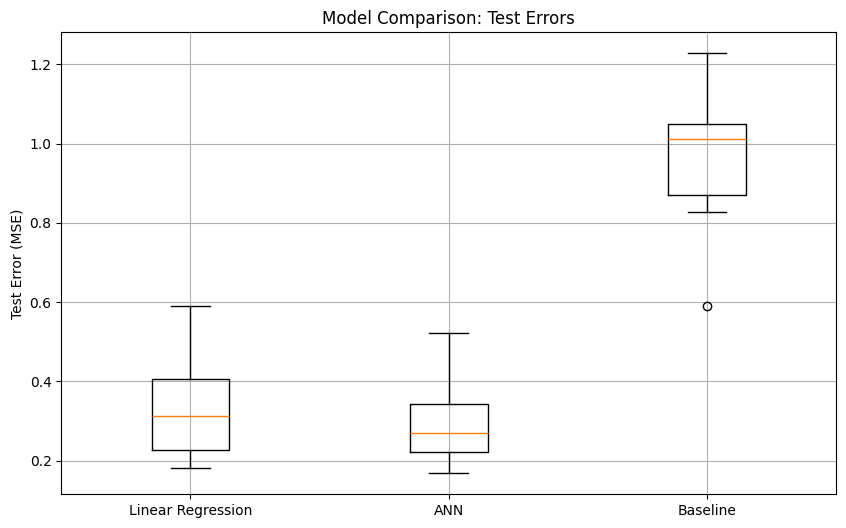

In [11]:
# Convert results into a DataFrame
results_df = pd.DataFrame(results_table)

# Display the table
print("\nTwo-level Cross-Validation Table:")
print(results_df)

# Visualize Test Errors for Each Model
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(
    [
        results_df["Linear Regression (E_test)"],
        results_df["ANN (E_test)"],
        results_df["Baseline (E_test)"],
    ],
    labels=["Linear Regression", "ANN", "Baseline"],
)
plt.ylabel("Test Error (MSE)")
plt.title("Model Comparison: Test Errors")
plt.grid()
plt.show()

In [12]:
# Extract test errors from the results table
ridge_errors = results_df["Linear Regression (E_test)"]
ann_errors = results_df["ANN (E_test)"]
baseline_errors = results_df["Baseline (E_test)"]

# Pairwise t-tests
print("Paired t-tests:")
ann_vs_ridge_t, ann_vs_ridge_p = ttest_rel(ann_errors, ridge_errors)
print(f"ANN vs. Linear Regression: t={ann_vs_ridge_t:.4f}, p={ann_vs_ridge_p:.4f}")

ann_vs_baseline_t, ann_vs_baseline_p = ttest_rel(ann_errors, baseline_errors)
print(f"ANN vs. Baseline: t={ann_vs_baseline_t:.4f}, p={ann_vs_baseline_p:.4f}")

ridge_vs_baseline_t, ridge_vs_baseline_p = ttest_rel(ridge_errors, baseline_errors)
print(f"Linear Regression vs. Baseline: t={ridge_vs_baseline_t:.4f}, p={ridge_vs_baseline_p:.4f}")

# Interpret results
alpha = 0.05
print("\nInterpretation:")
print(f"ANN vs. Linear Regression: {'Significant' if ann_vs_ridge_p < alpha else 'Not significant'}")
print(f"ANN vs. Baseline: {'Significant' if ann_vs_baseline_p < alpha else 'Not significant'}")
print(f"Linear Regression vs. Baseline: {'Significant' if ridge_vs_baseline_p < alpha else 'Not significant'}")

Paired t-tests:
ANN vs. Linear Regression: t=-3.4674, p=0.0071
ANN vs. Baseline: t=-12.4011, p=0.0000
Linear Regression vs. Baseline: t=-11.4606, p=0.0000

Interpretation:
ANN vs. Linear Regression: Significant
ANN vs. Baseline: Significant
Linear Regression vs. Baseline: Significant


In [13]:
# Calculate differences between test errors
diff_ann_vs_ridge = ann_errors - ridge_errors
diff_ann_vs_baseline = ann_errors - baseline_errors
diff_ridge_vs_baseline = ridge_errors - baseline_errors

# Compute mean and standard error of differences
mean_diff_ann_ridge = np.mean(diff_ann_vs_ridge)
se_diff_ann_ridge = np.std(diff_ann_vs_ridge, ddof=1) / np.sqrt(len(diff_ann_vs_ridge))

mean_diff_ann_baseline = np.mean(diff_ann_vs_baseline)
se_diff_ann_baseline = np.std(diff_ann_vs_baseline, ddof=1) / np.sqrt(len(diff_ann_vs_baseline))

mean_diff_ridge_baseline = np.mean(diff_ridge_vs_baseline)
se_diff_ridge_baseline = np.std(diff_ridge_vs_baseline, ddof=1) / np.sqrt(len(diff_ridge_vs_baseline))

# Compute 95% confidence intervals
ci_ann_ridge = (mean_diff_ann_ridge - 1.96 * se_diff_ann_ridge, mean_diff_ann_ridge + 1.96 * se_diff_ann_ridge)
ci_ann_baseline = (mean_diff_ann_baseline - 1.96 * se_diff_ann_baseline, mean_diff_ann_baseline + 1.96 * se_diff_ann_baseline)
ci_ridge_baseline = (mean_diff_ridge_baseline - 1.96 * se_diff_ridge_baseline, mean_diff_ridge_baseline + 1.96 * se_diff_ridge_baseline)

# Print results
print("\nConfidence Intervals (Setup II):")
print(f"ANN vs. Linear Regression: mean={mean_diff_ann_ridge:.4f}, 95% CI={ci_ann_ridge}")
print(f"ANN vs. Baseline: mean={mean_diff_ann_baseline:.4f}, 95% CI={ci_ann_baseline}")
print(f"Linear Regression vs. Baseline: mean={mean_diff_ridge_baseline:.4f}, 95% CI={ci_ridge_baseline}")


Confidence Intervals (Setup II):
ANN vs. Linear Regression: mean=-0.0332, 95% CI=(np.float64(-0.05196126626790315), np.float64(-0.014431341800929087))
ANN vs. Baseline: mean=-0.6599, 95% CI=(np.float64(-0.764209690791731), np.float64(-0.5556116538081154))
Linear Regression vs. Baseline: mean=-0.6267, 95% CI=(np.float64(-0.7338953611727924), np.float64(-0.5195333753582215))
